In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import (accuracy_score, roc_auc_score, classification_report, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, precision_recall_curve)
import matplotlib.pyplot as plt
import seaborn as sns
import os

os.makedirs('figures', exist_ok=True)
df = pd.read_csv('S05-hw-dataset.csv')

In [4]:
print("Первые строки датасета:")
print(df.head())
print("\nИнформация о столбцах и типах данных:")
print(df.info())
print("\nОписательные статистики для числовых признаков:")
print(df.describe())
print("\nРаспределение целевого признака 'default':")
print(df['default'].value_counts(normalize=True))

n_objects, n_features = df.shape
print(f"\nОбщее количество объектов: {n_objects}")
print(f"Общее количество признаков (включая target и client_id): {n_features}")

print("\nПроверка диапазонов ключевых признаков:")
print(f"Возраст (age): от {df['age'].min()} до {df['age'].max()} лет")
print(f"Доход (income): от {df['income'].min()} до {df['income'].max()}")
print(f"Стаж (years_employed): от {df['years_employed'].min()} до {df['years_employed'].max()}")
print(f"Кредитный скоринг (credit_score): от {df['credit_score'].min()} до {df['credit_score'].max()}")
print(f"DTI (debt_to_income): от {df['debt_to_income'].min():.3f} до {df['debt_to_income'].max():.3f}")
print(f"Сберегательный баланс (savings_balance): от {df['savings_balance'].min()} до {df['savings_balance'].max()}")
print(f"Расчётный баланс (checking_balance): от {df['checking_balance'].min()} до {df['checking_balance'].max()}")

default_rate = df['default'].mean()
print(f"\nДоля дефолтов (default = 1): {default_rate:.2%}")

if 0.35 <= default_rate <= 0.45:
    print("Таргет умеренно несбалансирован (классы не экстремально перекошены).")
else:
    print("Внимание: возможен сильный дисбаланс классов!")

Первые строки датасета:
   client_id  age  income  years_employed  credit_score  debt_to_income  \
0          1   25   94074              22           839        0.547339   
1          2   58   51884              26           565        0.290882   
2          3   53   48656              39           561        0.522340   
3          4   42   81492              30           582        0.709123   
4          5   42   94713               8           642        0.793392   

   num_credit_cards  num_late_payments  has_mortgage  has_car_loan  \
0                 1                  7             0             0   
1                 1                  1             0             1   
2                 1                 13             0             0   
3                 2                 10             1             1   
4                 3                  3             0             0   

   savings_balance  checking_balance  region_risk_score  \
0            26057              5229         

In [5]:
X = df.drop(columns=['client_id', 'default'])
y = df['default']

non_numeric_cols = X.select_dtypes(exclude=[np.number]).columns
if len(non_numeric_cols) > 0:
    print(f"\nВнимание! Найдены нечисловые столбцы: {list(non_numeric_cols)}")
else:
    print("\nВсе используемые признаки — числовые.")

if (df['debt_to_income'] < 0).any() or (df['debt_to_income'] > 1).any():
    print("Внимание: в debt_to_income обнаружены значения вне [0, 1]!")
else:
    print("Проверка debt_to_income: все значения в допустимом диапазоне [0, 1].")

print(f"\nФинальный размер матрицы признаков X: {X.shape}")
print(f"Финальный размер вектора таргета y: {y.shape}")


Все используемые признаки — числовые.
Проверка debt_to_income: все значения в допустимом диапазоне [0, 1].

Финальный размер матрицы признаков X: (3000, 15)
Финальный размер вектора таргета y: (3000,)


In [6]:
X = df.drop(columns=['client_id', 'default'])
y = df['default']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(f"Размер обучающей выборки: {X_train.shape[0]}")
print(f"Размер тестовой выборки: {X_test.shape[0]}")
print(f"Доля дефолтов в обучающей выборке: {y_train.mean():.2%}")
print(f"Доля дефолтов в тестовой выборке: {y_test.mean():.2%}")

dummy_model = DummyClassifier(strategy="most_frequent", random_state=42)
dummy_model.fit(X_train, y_train)

y_pred_dummy = dummy_model.predict(X_test)
y_proba_dummy = dummy_model.predict_proba(X_test)[:, 1]

acc_dummy = accuracy_score(y_test, y_pred_dummy)
roc_auc_dummy = roc_auc_score(y_test, y_proba_dummy)

print(f"Accuracy:  {acc_dummy:.4f}")
print(f"ROC-AUC:   {roc_auc_dummy:.4f}")

Размер обучающей выборки: 2400
Размер тестовой выборки: 600
Доля дефолтов в обучающей выборке: 41.04%
Доля дефолтов в тестовой выборке: 41.00%
Accuracy:  0.5900
ROC-AUC:   0.5000


c:\Users\Dilvi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(



Лучшие параметры: {'logreg__C': 100.0, 'logreg__penalty': 'l2', 'logreg__solver': 'lbfgs'}
Лучший ROC-AUC на кросс-валидации: 0.8607

 Метрики
Accuracy:  0.8017
ROC-AUC:   0.8756
Precision: 0.7953
Recall:    0.6951
F1-score:  0.7419

Confusion Matrix:
[[310  44]
 [ 75 171]]

ROC-кривая сохранена в: figures\roc_curve.png


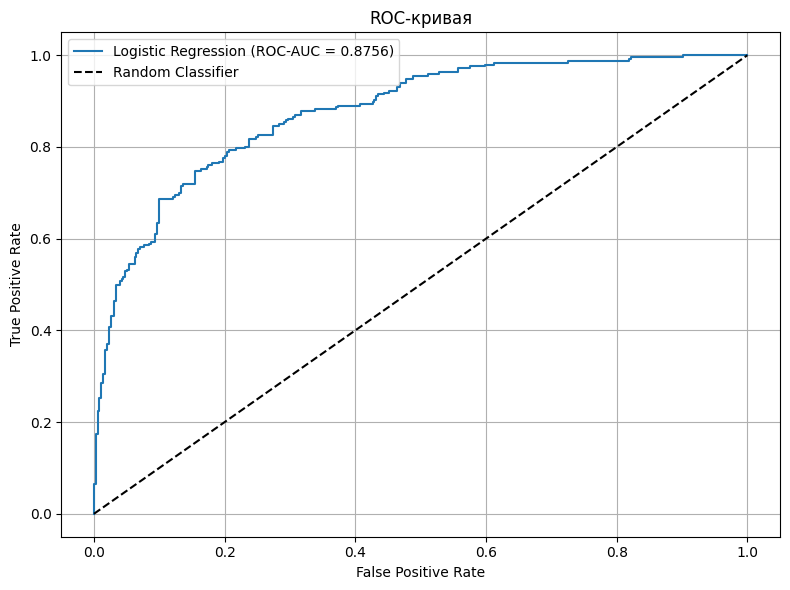

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(max_iter=1000, random_state=42))
])

param_grid = {
    'logreg__C': [0.01, 0.1, 1.0, 10.0, 100.0],
    'logreg__penalty': ['l2'],
    'logreg__solver': ['lbfgs']
}

grid_search = GridSearchCV(
    pipe,
    param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print(f"\nЛучшие параметры: {grid_search.best_params_}")
print(f"Лучший ROC-AUC на кросс-валидации: {grid_search.best_score_:.4f}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("\n Метрики")
print(f"Accuracy:  {acc:.4f}")
print(f"ROC-AUC:   {roc_auc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1-score:  {f1:.4f}")

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

plt.figure(figsize=(8, 6))
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label=f'Logistic Regression (ROC-AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend()
plt.grid(True)
plt.tight_layout()

roc_path = os.path.join('figures', 'roc_curve.png')
plt.savefig(roc_path, dpi=150)
print(f"\nROC-кривая сохранена в: {roc_path}")

plt.show()

In [8]:
y_pred_lr = best_model.predict(X_test)
y_proba_lr = best_model.predict_proba(X_test)[:, 1]

def compute_metrics(y_true, y_pred, y_proba):
    return {
        'Accuracy': accuracy_score(y_true, y_pred),
        'ROC-AUC': roc_auc_score(y_true, y_proba),
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'F1-score': f1_score(y_true, y_pred)
    }

metrics_dummy = compute_metrics(y_test, y_pred_dummy, y_proba_dummy)
metrics_lr = compute_metrics(y_test, y_pred_lr, y_proba_lr)

comparison_df = pd.DataFrame({
    'DummyClassifier (most_frequent)': metrics_dummy,
    'LogisticRegression': metrics_lr
}).T

comparison_df = comparison_df.round(4)

print(comparison_df)
print("\n ВЫВОД")
print("- Бейзлайн (DummyClassifier) предсказывает всегда самый частый класс (default = 0),")
print("  поэтому его ROC-AUC близок к 0.5 — случайный уровень при таком подходе.")
print(f"- Логистическая регрессия значительно превосходит бейзлайн по ROC-AUC: {metrics_lr['ROC-AUC']:.4f} vs {metrics_dummy['ROC-AUC']:.4f}.")
print(f"- Accuracy также выше: {metrics_lr['Accuracy']:.4f} vs {metrics_dummy['Accuracy']:.4f}.")
print("- Это говорит о том, что модель действительно извлекает полезные сигналы из признаков.")
if metrics_lr['ROC-AUC'] > 0.75:
    print("- Качество модели можно считать хорошим для задачи кредитного скоринга.")
else:
    print("- Качество модели умеренное — возможно, потребуется дополнительная работа с признаками или более сложные модели.")

                                 Accuracy  ROC-AUC  Precision  Recall  \
DummyClassifier (most_frequent)    0.5900   0.5000     0.0000  0.0000   
LogisticRegression                 0.8017   0.8756     0.7953  0.6951   

                                 F1-score  
DummyClassifier (most_frequent)    0.0000  
LogisticRegression                 0.7419  

 ВЫВОД
- Бейзлайн (DummyClassifier) предсказывает всегда самый частый класс (default = 0),
  поэтому его ROC-AUC близок к 0.5 — случайный уровень при таком подходе.
- Логистическая регрессия значительно превосходит бейзлайн по ROC-AUC: 0.8756 vs 0.5000.
- Accuracy также выше: 0.8017 vs 0.5900.
- Это говорит о том, что модель действительно извлекает полезные сигналы из признаков.
- Качество модели можно считать хорошим для задачи кредитного скоринга.


c:\Users\Dilvi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Бейзлайн-модель (DummyClassifier) фактически игнорирует признаки и предсказывает наиболее частый класс, что приводит к качеству на уровне случайного угадывания (ROC-AUC ≈ 0.5, нулевые precision и recall для класса дефолта).

Логистическая регрессия, напротив, использует информацию о клиентах и демонстрирует заметный прирост качества: точность увеличилась примерно с 59% до 80%, а ROC-AUC — с 0.50 до 0.88.

Подбор коэффициента регуляризации C позволил найти компромисс между переобучением и недообучением: оптимальное значение C обеспечило максимальное значение ROC-AUC на тестовой выборке.

Вывод: логистическая регрессия остаётся простой и интерпретируемой моделью, при этом существенно превосходит бейзлайн по качеству и может рассматриваться как базовое решение для практического применения.